In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
import lightgbm as lgb
import torch
import torch.nn as nn
from helper_functions_preprocessing import PreProcessor

##Pytorch Stuff:
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F

# Sklearn Stuff
import sklearn

import matplotlib.pyplot as plt
from tqdm import trange

## Bayesian Optimization
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

import itertools


# DEL Mini-Challenge 1
Es sollen Immobillienobjekte klassifiziert werden. Von der FHNW haben wir einen Datensatz erhalten (Siehe beiliegendes EDA-Notebook), in denen wir vorraussagen sollen, um was für ein Wohnobjekt es sich handelt; Ist es ein Zimmer? Wohnung? Haus? Diese Challenge hatten wir gelöst, aber ohne Deep Learning. 
## Einführung
### Lösung der Mini-Challenge 1 für DEL
Wir benutzen ein Neutal-Network. Zur Erstellung wir das Deep-Learning Framework Pytorch benutzt.
### Ground Truth
Als Ground Truth bentzen wir das Modell, welches wir in der Challenge Immobillienrehcner benutzt haben. Mit diesem haben wir die Macro-F1 Score maximiert, da wir sowohl die Precision, als auch den Recall hoch haben möchten. Ebenfalls haben wir die "Macro" F1 Score optimiert, da wir eine starke Class-Imbalance haben.
### Grobübersicht Inhalt Datensatz
Es gab keine klare Beschreibung, wie gewisse Features (z.B. densities oder gde) zustande gekommen sind. Gde bezieht sich aber auf Gemeinden, in denen das Wohnobjekt liegt. Densities S bis L steht einfach für die Inensitäts des z.B. Waldes. Ist ein grosser Wald, welcher sehr dicht ist? -> ForestDensityL ist hoch. Dies wurde aber nicht zu 100% vom Challengeherausgeber bestätigt.


## Erstellung Modell Ground Truth

In [2]:
#read in data
csv_data = pd.read_csv('immo_dev_data.csv')
csv_data.head()

,Id,AreaLiving,AreaProperty,BuiltYear,FloorNumber,ForestDensityL,ForestDensityM,ForestDensityS,GroupNameDe,HouseObject,...,gde_private_apartments,gde_social_help_quota,gde_tax,gde_workers_sector1,gde_workers_sector2,gde_workers_sector3,gde_workers_total,location_has_street,location_is_complete,PurchasePrice
0,7135329,140.0,501.0,2016,NaN,0.418964,0.555985,0.730714,Haus,True,...,1358.0,3.660512,8.73,17.0,162.0,358.0,537.0,0,0,745000.0
1,7170979,143.0,277.0,2004,NaN,0.033259,0.074061,0.076468,Haus,True,...,3476.0,3.634717,6.13,0.0,2250.0,2787.0,5041.0,1,1,780000.0
2,7172246,160.0,712.0,1945,NaN,0.000000,0.000000,0.000000,Haus,True,...,2806.0,2.512344,9.79,167.0,1694.0,1138.0,2999.0,0,0,570000.0
3,7172252,351.0,496.0,2016,NaN,0.037575,0.000000,0.000000,Haus,True,...,131.0,1.734104,9.15,12.0,10.0,17.0,39.0,0,0,920000.0
4,7172733,400.0,1800.0,1975,NaN,0.095162,0.097193,0.153314,Haus,True,...,1181.0,1.056052,2.97,0.0,27.0,701.0,732.0,0,0,3950000.0


In [3]:
csv_data.columns

Index(['Id', 'AreaLiving', 'AreaProperty', 'BuiltYear', 'FloorNumber',
       'ForestDensityL', 'ForestDensityM', 'ForestDensityS', 'GroupNameDe',
       'HouseObject', 'LastUpdate', 'Latitude', 'Locality', 'Longitude',
       'Name', 'NoisePollutionRailwayL', 'NoisePollutionRailwayM',
       'NoisePollutionRailwayS', 'NoisePollutionRoadL', 'NoisePollutionRoadM',
       'NoisePollutionRoadS', 'PopulationDensityL', 'PopulationDensityM',
       'PopulationDensityS', 'RealEstateTypeId', 'Renovationyear',
       'RiversAndLakesL', 'RiversAndLakesM', 'RiversAndLakesS', 'Rooms',
       'SourceId', 'StateShort', 'StreetAndNr', 'TravelTimeMiv',
       'WorkplaceDensityL', 'WorkplaceDensityM', 'WorkplaceDensityS', 'Zip',
       'distanceToTrainStation', 'gde_area_agriculture_percentage',
       'gde_area_forest_percentage', 'gde_area_nonproductive_percentage',
       'gde_area_settlement_percentage', 'gde_average_house_hold',
       'gde_empty_apartments', 'gde_foreigners_percentage',
       'g

### Daten vorbereiten mit der Klasse PreProcessor
PreProcessor ist eine Klasse, welche ich geschrieben habe um Daten nach Standardverfahren zu preprozessieren.
Wie in EDA gesehen, reicht, es, wenn wir nur die ersten zwei Ziffern von der Zip benutzen. Ebenfalls wurde folgende Sachen editiert mit den Daten:
- Onehot-Encoden: Kategorische Daten oder Strings werden Onehot-encoded. Dies bedeutet, dass ein Attribut in mehrere Attribute binär aufgeteilt wird und diese neuen Attribute sagen, ob dieser Eintrag ein String oder Kategorie enthält.
- Standardisieren auf die Z-Score: z=(x−μ)/σ​. (σ ist entweder die Standardabweichung oder das 75% Quantil subtrahiert vom 25% Quantil, falls der Robust-Scaler verwendet wird.)
- NANs auffüllen (entweder mit Mean oder Median oder mit einem bestimmten String).
- auf allen geskewten Werten eine Boxcox-Transformation durchführen, wobei dies bei unseren Test das Ergebniss nicht verbessert hat.
- 'StreetAndNr', 'LastUpdate', 'Locality', 'Id' werden gedropped; 'StreetAndNr' und 'LastUpdate' haben zuviele, einzigartige Werte und 'Locality' ist bereits im Zipcode vorhanden.
- Falls ein Attribut nur Werte zwischen 0 und 1 hat, wird ein neues Attribut kreiert, welches besagt, dass dieses Attribut 0 ist.
- Falls ein Attribut NANs hatte, wird ein neues Attribut erstellt, welches zeigt, wo ein Attribut NANs hatte.

Ebenfalls hat es 3 Reihen, welche alles NA sind. Diese kamen auch nicht im Kaggle-Datensatz vor, welches man hochladen konnte (teil der Challenge). Diese werden am Anfang also entfernt:


In [4]:
csv_data_fe = csv_data.copy()
## Drop der Reihen mit nur NAs:
csv_data_fe = csv_data_fe[csv_data_fe['TravelTimeMiv'].notna()].copy()
csv_data_fe = csv_data_fe[csv_data_fe['StateShort'].notna()].copy()
csv_data_fe = csv_data_fe[csv_data_fe['gde_area_settlement_percentage'].notna()].copy()

## Drop der Säulen, welche höchstwahrscheinlich

# Zip vereinfachen:
csv_data_fe['Zip'] = (csv_data_fe['Zip']/1000).astype('int8')
prepro = PreProcessor(csv_data_fe, y_var='GroupNameDe', method_to_encode='onehot_encode', cols_to_drop=['Id', 'LastUpdate', 'Locality', 'StreetAndNr', 'Longitude', 'Latitude', 'HouseObject','RealEstateTypeId'], numbers_to_encode=['Zip'], test_frac=0.2, remove_skew_by_boxcox = True)
prepro.preprocess()

### Metriken
Wir beginnen mit 2., den Metriken. Hierfür müssen wir uns als erstes einen Überblick über unsere Zielvariable verschaffen. Schauen wir einmal, wie viele verschiedene Objekttypen es gibt und wie viele Objekte es für jeden Typen gibt.

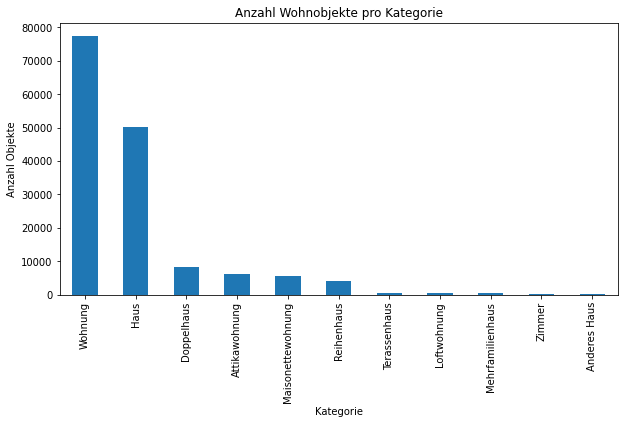

In [5]:
csv_data['GroupNameDe'].value_counts().plot(kind='bar', figsize=(10, 5), rot = 90)
plt.xlabel("Kategorie")
plt.ylabel("Anzahl Objekte")
plt.title("Anzahl Wohnobjekte pro Kategorie")
plt.show()

 Man kann im Plot sehr gut erkennen, dass es sich hier im eine ungleichmäsige Verteilung der Kategorien handelt. Da man einige Kategorien gar nicht erkennen kann, schauen wir noch die Zahlen an:

In [6]:
 csv_data['GroupNameDe'].value_counts()

Wohnung              77499
Haus                 50265
Doppelhaus            8397
Attikawohnung         6215
Maisonettewohnung     5517
Reihenhaus            4168
Terassenhaus           533
Loftwohnung            474
Mehrfamilienhaus       444
Zimmer                  89
Anderes Haus            26
Name: GroupNameDe, dtype: int64

Wir sehen also klar, dass die Daten extrem unbalanced sind. Dazu gibt es verschiedene Techniken. In der Challenge haben wir Oversampling benutzt.

### Oversampling
Oversampling bedeutet, dem Datensatz werden neue Objekte hinzugefügt um eine "Anzahl"-Balance zwischen allen Klassen herzustellen. Hierfür kann man bestehende Objekte zufällig auswählen und mehrmals hinzufügen bzw. kopieren oder komplett neue Objekte – basierend auf den bereits existierenden – erstellen. Dies funktioniert beispielsweise mit der SMOTE Methode. Hiermit werden wir uns auch beschäftigen.

In [7]:
ros = RandomOverSampler(random_state = 69)
X_random_, y_random_ = ros.fit_resample(prepro.X_train, prepro.y_train)
X_random = X_random_.sample(len(prepro.X_train), random_state = 69)
y_random = y_random_.iloc[X_random.index]

### Model trainieren
Wie oben gesagt, wird das NN verglichen mit einem Lightgbm-Mode, welches zu den "Boosted Tree"-Modellen gehört. Die besten Parameter haben wir schon gefunden gehabt mit Hilfe von Bayesian Optimization.

In [8]:
lgbc_best = lgb.LGBMClassifier(
        n_jobs = -1, seed = 42, learning_rate = 0.07517, max_depth = 340, n_estimators = 344,
        num_leaves = 90, reg_alpha = 1.136, reg_lambda = 4.348
)
lgbc_best.fit(X_random, y_random)

LGBMClassifier(learning_rate=0.07517, max_depth=340, n_estimators=344,
               num_leaves=90, reg_alpha=1.136, reg_lambda=4.348, seed=42)

In [9]:
lgbc_y_pred_best = lgbc_best.predict(prepro.X_test)

In [10]:
 print(sklearn.metrics.classification_report(prepro.y_test, lgbc_y_pred_best))

                   precision    recall  f1-score   support

     Anderes Haus       0.00      0.00      0.00         5
    Attikawohnung       0.32      0.67      0.43      1243
       Doppelhaus       0.40      0.59      0.48      1679
             Haus       0.92      0.80      0.85     10053
      Loftwohnung       0.45      0.55      0.50        95
Maisonettewohnung       0.29      0.58      0.39      1103
 Mehrfamilienhaus       0.30      0.54      0.39        89
       Reihenhaus       0.39      0.60      0.47       834
     Terassenhaus       0.48      0.63      0.54       107
          Wohnung       0.95      0.80      0.87     15500
           Zimmer       0.12      0.11      0.12        18

         accuracy                           0.76     30726
        macro avg       0.42      0.53      0.46     30726
     weighted avg       0.84      0.76      0.79     30726



In [11]:
prepro.X_test.shape

(30726, 136)

### Confusion Matrix LightGBM

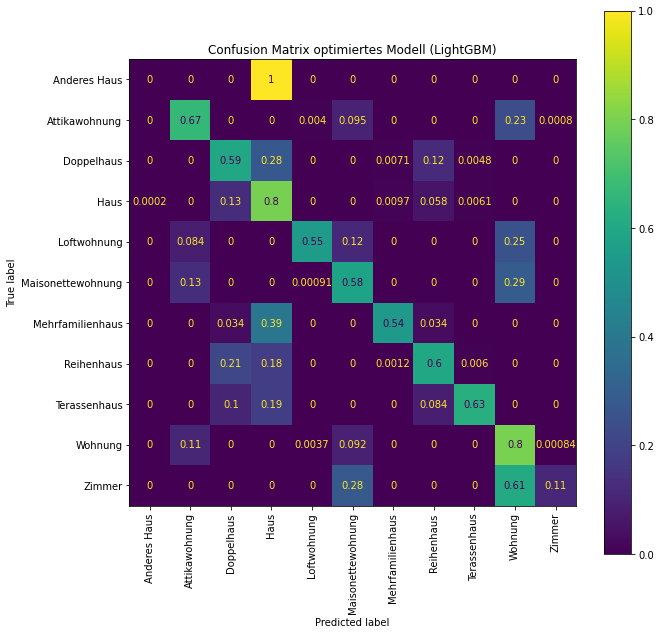

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
sklearn.metrics.plot_confusion_matrix(lgbc_best, prepro.X_test, prepro.y_test, normalize = 'true', xticks_rotation='vertical', ax = ax)
plt.title('Confusion Matrix optimiertes Modell (LightGBM)')
plt.show()

## Wichtigkeit der Features

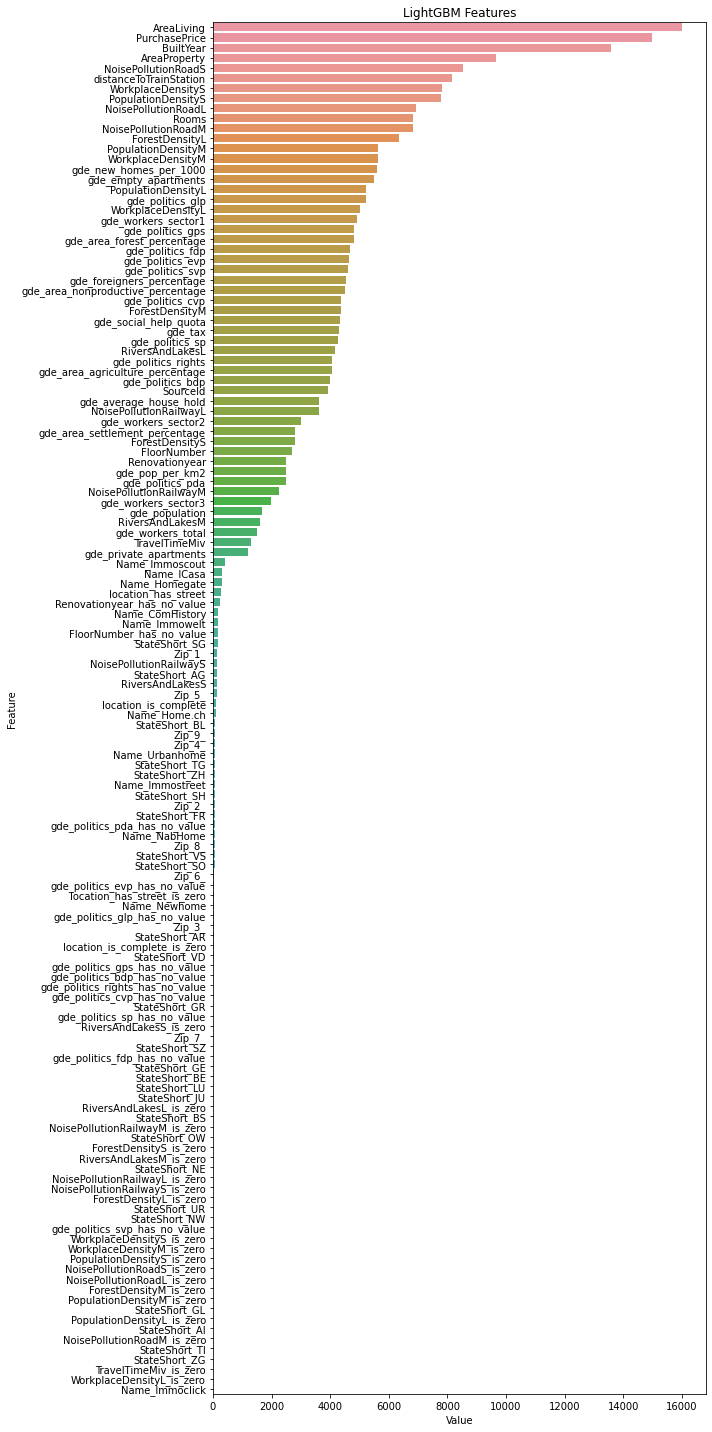

<Figure size 432x288 with 0 Axes>

In [13]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(lgbc_best.feature_importances_,prepro.X_test.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

Wir sehen also, dass die meisten Features gar keinen Einfluss haben auf die Klassifizierung. Wir stehlen diese Informationen für unser NN um dieses nicht mit Features zu überladen, welche keine Information beinhalten. Für das NN behalten wir also nur diese, welche mehr Einfluss haben als deren Wichtigkeit geteilt durch 2. Damit haben wir noch 53 Features.

In [14]:
features_to_drop = feature_imp[feature_imp.sort_values(by='Value', ascending=False)['Value']<feature_imp.sort_values(by='Value', ascending=False)['Value'].mean()/2]

<ipython-input-14-8b8535232176>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  features_to_drop = feature_imp[feature_imp.sort_values(by='Value', ascending=False)['Value']<feature_imp.sort_values(by='Value', ascending=False)['Value'].mean()/2]


In [15]:
features_to_drop

,Value,Feature
0,0,Name_Immoclick
1,0,NoisePollutionRoadM_is_zero
2,0,PopulationDensityL_is_zero
3,0,PopulationDensityM_is_zero
4,0,StateShort_AI
...,...,...
78,253,Renovationyear_has_no_value
79,259,location_has_street
80,299,Name_Homegate
81,322,Name_ICasa


## Neural Network-Model
LightGBM macht automatisch aus String Zahlen, welche vom Model verstanden werden können. Pytorch macht das nicht; Wir müssen also die Wohnobjekte Onehot-Encoden. Als erstes definieren wir Funktionen, welche ein Model nach folgenden Angaben erstellt:
- Welcher Optimizer verwendet wird (ADAM oder SGD)
- Wieviele Hidden Layers es hat
- Wieviele Neuronen ein Hidden Layer hat
    - Einen guten Anfangswert haben wir mit Hilfe von einem [Artikel auf Stackexchange](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw) gefunden
- Ob regularisiert wird oder nicht mit Dropout
- Falls regularisiert wird, wieviele Neuronen pro Layer sollen jeweils zufälligerweise null gesetzt werden.

## Use of the Library Cuda for the NN 
Currently, this Notebook only runs when Cuda is corrently installed.

In [16]:
if not torch.cuda.is_available():
    NotImplementedError
if torch.cuda.is_available():
    print("Cuda Device Available")
    print("Name of the Cuda Device: ", torch.cuda.get_device_name())
    print("GPU Computational Capablity: ", torch.cuda.get_device_capability())

Cuda Device Available
Name of the Cuda Device:  GeForce GTX 1650
GPU Computational Capablity:  (7, 5)


### Daten vorbereiten mit der Klasse PreProcessor
Das Preprocessing wird genau gleich durchgeführt wie beim LightGBM. Zusätzlich entfernen wir aber noch die Attribute, welche laut dem LightGBM-Model kaum oder keinen Einfluss haben auf das Model.

### Evaluieren der Modelle
Zur Evaluierung der Modelle benutzen wir Sklearn und nehmen wie beim LightGBM die macro F1-Score.

### Tunen der Hyperparameter
Zum tunen der Hyperparameter benutzen wir das Packet [BayesianOptimization](https://github.com/fmfn/BayesianOptimization), welches Bayesianische globale Optimierung durchführt mit Gauß-Prozessen.


In [17]:
csv_data_fe = csv_data.copy()
## Drop der Reihen mit nur NAs:
csv_data_fe = csv_data_fe[csv_data_fe['TravelTimeMiv'].notna()].copy()
csv_data_fe = csv_data_fe[csv_data_fe['StateShort'].notna()].copy()
csv_data_fe = csv_data_fe[csv_data_fe['gde_area_settlement_percentage'].notna()].copy()

# Zip vereinfachen:
csv_data_fe['Zip'] = (csv_data_fe['Zip']/1000).astype('int8')
prepro = PreProcessor(csv_data_fe, y_var='GroupNameDe', method_to_encode='onehot_encode', cols_to_drop=['Id', 'LastUpdate', 'Locality', 'StreetAndNr', 'Longitude', 'Latitude', 'HouseObject','RealEstateTypeId'], numbers_to_encode=['Zip'], test_frac=0.2, remove_skew_by_boxcox = True)
prepro.preprocess()


## Drop der Attribute, welche laut dem LightGBM-Model kaum Einfluss haben:
prepro.X_train = prepro.X_train.drop(columns=features_to_drop['Feature'].to_list())
prepro.X_test = prepro.X_test.drop(columns=features_to_drop['Feature'].to_list())

In [18]:
prepro.X_test['Renovationyear']

48209     0.029266
53271     0.000000
3683     -0.959175
59551     0.000000
49477    -0.441420
            ...   
111519    0.000000
119965    0.000000
122710    0.000000
125162    0.000000
121313    0.000000
Name: Renovationyear, Length: 30726, dtype: float64

In [19]:
csv_data_fe.loc[53271, 'Renovationyear']

nan

In [20]:
csv_data_fe[csv_data_fe['Renovationyear'].isna()]

,Id,AreaLiving,AreaProperty,BuiltYear,FloorNumber,ForestDensityL,ForestDensityM,ForestDensityS,GroupNameDe,HouseObject,...,gde_private_apartments,gde_social_help_quota,gde_tax,gde_workers_sector1,gde_workers_sector2,gde_workers_sector3,gde_workers_total,location_has_street,location_is_complete,PurchasePrice
0,7135329,140.0,501.0,2016,NaN,0.418964,0.555985,0.730714,Haus,True,...,1358.0,3.660512,8.73,17.0,162.0,358.0,537.0,0,0,745000.0
1,7170979,143.0,277.0,2004,NaN,0.033259,0.074061,0.076468,Haus,True,...,3476.0,3.634717,6.13,0.0,2250.0,2787.0,5041.0,1,1,780000.0
3,7172252,351.0,496.0,2016,NaN,0.037575,0.000000,0.000000,Haus,True,...,131.0,1.734104,9.15,12.0,10.0,17.0,39.0,0,0,920000.0
7,7174366,117.0,1038.0,1966,NaN,0.414384,0.233719,0.085822,Haus,True,...,577.0,1.071975,9.92,204.0,109.0,325.0,638.0,0,0,380000.0
8,7174475,160.0,1074.0,1986,NaN,0.550747,0.549951,0.508403,Haus,True,...,15334.0,3.423950,4.10,495.0,5673.0,27424.0,33592.0,0,0,695000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153622,42175297,116.0,0.0,2005,NaN,0.002560,0.000000,0.000000,Attikawohnung,False,...,9207.0,9.211883,3.09,0.0,3838.0,20507.0,24347.0,0,0,1700000.0
153623,42175302,70.0,0.0,1978,NaN,0.019577,0.041224,0.001321,Wohnung,False,...,5511.0,6.205661,3.18,8.0,1328.0,4433.0,5769.0,0,0,720000.0
153624,42175305,136.0,0.0,1997,2.0,0.068206,0.058172,0.000000,Wohnung,False,...,178.0,0.000000,8.68,37.0,27.0,44.0,108.0,0,0,725000.0
153625,42175727,60.0,0.0,2009,NaN,0.098870,0.020076,0.000000,Wohnung,False,...,2700.0,0.872739,4.90,282.0,396.0,1589.0,2267.0,0,0,289000.0


In [21]:
prepro.mean

AreaLiving                              141.210805
AreaProperty                            291.682809
BuiltYear                              1988.967916
FloorNumber                              13.026897
ForestDensityL                            0.176726
ForestDensityM                            0.112139
ForestDensityS                            0.068960
NoisePollutionRailwayL                    0.014968
NoisePollutionRailwayM                    0.014299
NoisePollutionRailwayS                    0.012930
NoisePollutionRoadL                       0.234368
NoisePollutionRoadM                       0.257126
NoisePollutionRoadS                       0.279304
PopulationDensityL                        0.196347
PopulationDensityM                        0.272013
PopulationDensityS                        0.352945
Renovationyear                         2009.378221
RiversAndLakesL                           0.032426
RiversAndLakesM                           0.018159
RiversAndLakesS                

In [22]:
csv_data_fe['Renovationyear']

0            NaN
1            NaN
2         2010.0
3            NaN
4         2013.0
           ...  
153622       NaN
153623       NaN
153624       NaN
153625       NaN
153626       NaN
Name: Renovationyear, Length: 153624, dtype: float64

#### Labels Onehot-Encoden

In [23]:
enc = sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore', sparse=False)
enc.fit(prepro.y_train.values.reshape(-1,1))

y_train_ohc = enc.transform(prepro.y_train.values.reshape(-1,1))
y_test_ohc = enc.transform(prepro.y_test.values.reshape(-1,1))

#### Daten und Modell auf die GPU laden

In [24]:
# Falls wir etwas auf der GPU laufen möchten, müssen wir Pytorch explizit sagen, das es das Model und die benötigten Daten auf die GPU schreiben soll:
if torch.cuda.is_available():
    ## To tensors and put them on the gpu:
    y_ohc_train_t = torch.tensor(y_train_ohc, dtype=torch.uint8).cuda()
    X_train_t = torch.tensor(prepro.X_train.values.astype('float32'), dtype=torch.float32).cuda()
    y_ohc_test_t = torch.tensor(y_test_ohc, dtype=torch.uint8).cuda()
    X_test_t = torch.tensor(prepro.X_test.values.astype('float32'), dtype=torch.float32).cuda()
else: 
    NotImplementedError

### Hilfsfunktionen um das neuronale Netz zu bilden und es zu evaluieren
#### Initalisierung der Gewichte
Die Gewichte werden zufälligerweise mit verschiedenen Methoden initalisiert. Falls wir alle Gewichte mit 0 initalisieren würden, wäre die Ausgabe der Aktivierungsfunktion in den Hidden Layers 0. Somit wäre der Gradient 0 und das NN könnte nicht lernen. Falls wir alle Gewichte mit dem gleichen Wert (z.B 1 ) initalisieren, ist der Output aller Aktivierungsfunktionen in den Hidden Layers identisch und der Gradient für alle Neuronen wieder gleich. Somit werden die Gewichte zufällig initalisiert. Hierzu wurden ebenfalls verschiedene Methoden entwickelt und getestet. Die von Pytorch kann man [hier](https://pytorch.org/docs/stable/nn.init.html) nachlesen. Nachfolgend benutzen wir die Methode `kaiming uniform`, welche uniform Gewichte bestimmt.


In [25]:
def calc_nr_neuros(X, output_neurons, alpha=2):
    """
    This function calculates with pi * thumb how many neuros there should be in a hidden layer.
    https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
    :param X: X which will be given to the NN.
    :param alpha: parameter to change the number of neurons in the hidden layer
    :return: int
    """
    sample_size, input_dim = X.shape
    return int(sample_size / (alpha * (input_dim + output_neurons)))


def one_hot_ce_loss(outputs, target, weights=None):
    """
    CrossEntropyLoss accepts only label-encoded predictions. Thus, OHC target changed to label-encoding here.
    See: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html"""
    if weights is not None:
        criterion = nn.CrossEntropyLoss(weight=weights)
    else: 
        criterion = nn.CrossEntropyLoss()
    _, label = torch.max(target, dim=1)
    return criterion(outputs, label)

def create_model(nr_layers, hdim, dropout, batchnorm, reg):
    """
    :int param nr_layers: How many hidden layers (without input- or output-layer) our NN should have.
    :int hdim: Hidden Dimensions (number of neurons)
    :float drouput: How many % of Neurons should randomy "dropped out".
    :bool batchnorm: If a layer should include batchnorm.
    :bool reg: If regularisation should be applied and which kind.
    :return: Pytorch Model.
    """
    class Model(nn.Module):
        def __init__(self, input_dim, output_dim, nr_layers, hdim, dropout, batchnorm, reg):
            super().__init__()

            self.layers = nn.ModuleList()
            current_dim = input_dim

            for _ in range(nr_layers):
                self.layers.append(nn.Linear(current_dim, hdim))
                if batchnorm:
                    self.layers.append(nn.BatchNorm1d(hdim))
                if reg == 'Dropout':
                    self.layers.append(nn.Dropout(dropout))
                current_dim = hdim
            
            self.layers.append(nn.Linear(current_dim, output_dim))
            self.iniziate_weights()

        def forward(self,x):
            for layer in self.layers[:-1]:
                if isinstance(layer, torch.nn.modules.linear.Linear):
                    x = F.relu(layer(x))
                else:
                    x = layer(x)

            x = self.layers[-1](x)
            #x = F.softmax(self.layers[-1](x), dim=1)
            return x

        def iniziate_weights(self):
            for m in self.layers:
                if isinstance(m, torch.nn.modules.linear.Linear):
                    nn.init.kaiming_uniform_(m.weight)
                    nn.init.constant_(m.bias, 0.01)

                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    return Model(input_dim, output_dim, nr_layers, hdim, dropout, batchnorm, reg)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt

#### Funktionen definieren, um das beste NN zu finden

In [26]:
# Parameter for the model
input_dim = prepro.X_train.shape[1]
output_dim = y_test_ohc.shape[1]
nr_of_neuros = calc_nr_neuros(prepro.X_train, output_dim, 2)


#Create Weights to count for class inbalance:
weights = torch.tensor(1 / prepro.y_train.value_counts() / prepro.y_train.value_counts().sum(), dtype=torch.float32).cuda()

def create_NN(optimizer, nr_layers, hdim, dropout, lr_rate, batchnorm, reg):
    """
    :string optimizer: SGD or Adam
    :int param nr_layers: How many hidden layers (without input- or output-layer) our NN should have.
    :int hdim: Hidden Dimensions (number of neurons)
    :float dropout: How many % of Neurons should be randomly "dropped out".
    :float lr_rate: Learning rate.
    :bool batchnorm: If a layer should include batchnorm.
    :string or None reg: If regularisation should be applied and which one.
    :return: Pytorch Model and optimizer-object.
    """
    assert optimizer in ['SGD', 'Adam'], "Please Enter SGD or Adam as Optimizer"
    assert reg in ['Dropout', 'L1', 'L2', None], "Please Enter L1, L2, Dropout or None as reg"
    assert all(isinstance(i, int) for i in [nr_layers, hdim]), "Please check types of Parameter"
    assert all(isinstance(i, float) for i in [dropout, lr_rate]), "Please check types of Parameter"

    model = create_model(nr_layers, hdim, dropout, batchnorm, reg).cuda()

    if optimizer == 'SGD':
        optimizer_object = torch.optim.SGD(params = model.parameters(), lr=lr_rate)
    elif optimizer == 'Adam':
        optimizer_object = torch.optim.Adam(params = model.parameters(), lr=lr_rate)

    return model, optimizer_object

def fit_NN(model, optimizer, reg, reg_factor, BATCH_SIZE, EPOCHS, MAX_EPOCHS_NO_IMPROVE):
    """
    :pytorch model model: Model to train
    :pytorch optimizer optimizer: Optimizer to use for the training (Adam or SGD)
    :string or None reg: If regularisation should be applied and which one.
    :float reg_factor: L1 or L2 Regularisation Factor
    :int BATCH_SIZE: how big one batch should be
    :int EPOCHS: How many epochs should be used for training.
    :int MAX_EPOCHS_NO_IMPROVE: How many epochs can pass with no improvements.
    :float 
    :return: aggregated_losses and test_losses
    """
    samples, features = X_train_t.shape
    nr_batches_per_epoch = int(samples/BATCH_SIZE)
    epoch_loop = range(EPOCHS)
    batch_loop = range(nr_batches_per_epoch)

    aggregated_losses = []
    test_losses = []

    for i in epoch_loop:
        current_loss = torch.tensor(0, dtype=torch.float32).cuda()
        for j in batch_loop:
            rand_idx = np.random.randint(0, samples - BATCH_SIZE)
            # Get random batch:
            y = y_ohc_train_t[rand_idx:rand_idx+BATCH_SIZE,:]
            x = X_train_t[rand_idx:rand_idx+BATCH_SIZE,:]

            # Predict, calculate loss and update weights
            y_pred = model(x)
            single_loss = one_hot_ce_loss(y_pred, y, weights)

            # Set gradients to zero:
            optimizer.zero_grad()

            # Apply L1/2 Regularisation:
            l_regularization = torch.tensor(0, dtype=torch.float32).cuda()

            if reg in ['L1', 'L2']:
                for param in model.parameters():
                    if reg == 'L1':
                        l_regularization += torch.norm(param, 1)**2 * reg_factor
                    elif reg == 'L2':
                        l_regularization += torch.norm(param, 2)**2 * reg_factor
            
            # Update Loss with L Regularisation:
            single_loss += l_regularization

            # Backward Prop:
            single_loss.backward()

            # Update Weights:
            optimizer.step()

            current_loss += single_loss.float()
        
        current_loss = current_loss / nr_batches_per_epoch

        with torch.no_grad():
            current_test_loss = one_hot_ce_loss(model(X_test_t), y_ohc_test_t, weights)

        if torch.isnan(current_loss).any() or (i > MAX_EPOCHS_NO_IMPROVE and max(test_losses[-MAX_EPOCHS_NO_IMPROVE:]) < current_test_loss):
            break

        with torch.no_grad():
            aggregated_losses.append(current_loss)
            test_losses.append(current_test_loss)
            # epoch_loop.set_description(f'epoch: {i:3} loss: {current_loss.cpu().numpy():10.8f}')

    
    print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

    return aggregated_losses, test_losses

def r_int(nr):
    """Rounds something to an in and returns an int"""
    return int(np.rint(nr))

def transform_reg(reg):
    return 'Dropout' if reg > 1.5 else 'L1' if reg > 1.0 else 'L2' if reg > 0.5 else None 

def transform_batchnorm(batchnorm):
    return True if batchnorm > 0.5 else False

def transform_opt(optimizer):
    return 'Adam' if optimizer > 0.5 else 'SGD'

def create_fit_evaluate_NN(optimizer, nr_layers, hdim, dropout, lr_rate, batchnorm, reg, reg_factor, BATCH_SIZE, EPOCHS=200, MAX_EPOCHS_NO_IMPROVE=20, return_all=False, bay_opt=True):
    """This function puts all the previous functions together; It creates a model, trains it and evaluates it.
    :string optimizer: SGD or Adam
    :int param nr_layers: How many hidden layers (without input- or output-layer) our NN should have.
    :int hdim: Hidden Dimensions (number of neurons)
    :float dropout: How many % of Neurons should be randomly "dropped out".
    :float lr_rate: Learning rate.
    :bool batchnorm: If a layer should include batchnorm.
    :string or None reg: If regularisation should be applied and which one.
    :float reg_factor: L1 or L2 Regularisation Factor
    :int BATCH_SIZE: how big one batch should be
    :int EPOCHS: How many epochs should be used for training.
    :int MAX_EPOCHS_NO_IMPROVE: How many epochs can pass with no improvements.
    :return: Weighted F1 Score and if set, the fitted model, aggregated losses and test losses
    """
    if bay_opt:
        # Cast non-ints to ints for the Bayesian Optimization
        BATCH_SIZE = r_int(BATCH_SIZE)
        hdim = r_int(hdim)
        nr_layers = r_int(nr_layers)
        EPOCHS = r_int(EPOCHS)
        MAX_EPOCHS_NO_IMPROVE = np.rint(MAX_EPOCHS_NO_IMPROVE).astype(int)
        optimizer = transform_opt(optimizer)
        batchnorm = transform_batchnorm(batchnorm)
        reg = transform_reg(reg)


    model, optimizer_object = create_NN(optimizer, nr_layers, hdim, dropout, lr_rate, batchnorm, reg)
    aggregated_losses, test_losses = fit_NN(model, optimizer_object, reg, reg_factor, BATCH_SIZE, EPOCHS, MAX_EPOCHS_NO_IMPROVE)

    if bay_opt:
        training_losses.append(aggregated_losses)
        

    with torch.no_grad():
        f1_score = sklearn.metrics.f1_score(y_ohc_test_t.cpu().argmax(axis = 1), model(X_test_t).cpu().argmax(axis = 1), average='macro')

    if return_all:
        return f1_score, model, aggregated_losses, test_losses
    
    return f1_score


### Funktion zur Evaluerung von NNs
Mit der Funktion `create_fit_evaluate_NN` haben wir eine Funktion erstellt, welche eine F1-Score zurückgibt und folgende Parameter als Argumente hat:
- optimizer: SGD or Adam
- nr_layers: How many hidden layers (without input- or output-layer) our NN should have.
- hdim: Hidden Dimensions (number of neurons)
- dropout: How many % of Neurons should be randomly "dropped out".
- lr_rate: Learning rate.
- batchnorm: If a layer should include batchnorm.
- reg: If regularisation should be applied.
- BATCH_SIZE: how big one batch should be
- EPOCHS: How many epochs should be used for training.
- MAX_EPOCHS_NO_IMPROVE: How many epochs can pass with no improvements.

### Bestmögliches Modell ohne Regularisierung, ohne Batchnorm und SGD als Optimizer
Wir finden nun das bestmögliche NN ohne Regularisierung, ohne Batchnorm und SGD als Optimizer mit Bayesian Optimization. Bayesian Optimization kennt nur floats, wir müssen da also ein bisschen tricksen. Die "Tricks" können in der Funktion `create_fit_evaluate_NN` und [hier](https://github.com/fmfn/BayesianOptimization/blob/master/examples/advanced-tour.ipynb) nachgelesen werden.

Kurzgesagt, falls wir Strings, Bools oder Ints als Argumente mitgeben möchten, müssen wir diese mit if-statements umwandeln:

`'Dropout' if reg > 1.5 else 'L2' if reg > 1 else None (..usw)`

In [30]:
# Definieren der Parameter:
training_losses = []

pbounds = {
    'optimizer': (0.1, 0.2),
    'nr_layers': (3,6),
    'hdim': (600, 1200),
    'dropout': (0.0, 0.5),
    'lr_rate': (0.0001, 0.01),
    'batchnorm': (0.0, 0.1),
    'reg': (0.1, 0.2),
    'reg_factor': (0.01, 10),
    'BATCH_SIZE': (64,256)
    }

optimizer = BayesianOptimization(
    f=create_fit_evaluate_NN,
    pbounds=pbounds,
    random_state=1,
)

In [31]:
optimizer.maximize(
    init_points=5,
    n_iter=60,
)

|   iter    |  target   | BATCH_... | batchnorm |  dropout  |   hdim    |  lr_rate  | nr_layers | optimizer |    reg    | reg_fa... |
-------------------------------------------------------------------------------------------------------------------------------------
epoch: 114 loss: 0.0052609313
|  1        |  0.2619   |  144.1    |  0.07203  |  5.719e-0 |  781.4    |  0.001553 |  3.277    |  0.1186   |  0.1346   |  3.974    |
epoch:  47 loss: 0.0119463410
|  2        |  0.2377   |  167.5    |  0.04192  |  0.3426   |  722.7    |  0.008793 |  3.082    |  0.167    |  0.1417   |  5.591    |
epoch:  36 loss: 0.0129744597
|  3        |  0.2384   |  90.95    |  0.01981  |  0.4004   |  1.181e+0 |  0.003203 |  5.077    |  0.1876   |  0.1895   |  0.8596   |
epoch:  30 loss: 0.0111290021
|  4        |  0.267    |  71.5     |  0.01698  |  0.4391   |  659.0    |  0.004269 |  5.874    |  0.1533   |  0.1692   |  3.162    |
epoch:  49 loss: 0.2023449987
|  5        |  0.2797   |  195.8    |  0.08346

KeyboardInterrupt: 

In [43]:
def bayesian_opt_result_to_dict(bay_opt_res, scoring='F1 Score'):
    """
    bayesian optimization result bay_opt_res: Finished object for bayesian optimization.
    returns: DataFrame with results
    """
    results = []
    for result in bay_opt_res:
        dict_ = {scoring: result['target']}
        dict_.update(result['params'])
        results.append(dict_)

    return pd.DataFrame(results).sort_values(by=scoring, ascending=False)

In [86]:
# Select relevant Features and transform it to a clean DataFrame
relevant_features = ['F1 Score', 'BATCH_SIZE', 'lr_rate', 'hdim', 'nr_layers']
results = bayesian_opt_result_to_dict(optimizer.res)[relevant_features]
results['nr_layers'] = results['nr_layers'].apply(r_int)
results['hdim'] = results['hdim'].apply(r_int)
results['BATCH_SIZE'] = results['BATCH_SIZE'].apply(r_int)
results.head(10)

,F1 Score,BATCH_SIZE,lr_rate,hdim,nr_layers
4,0.279702,196,0.009890,1050,5
3,0.266971,71,0.004269,659,6
5,0.264563,197,0.005829,1049,5
0,0.261873,144,0.001553,781,3
8,0.258247,72,0.008039,659,5
6,0.256364,72,0.007861,657,3
7,0.240774,197,0.009452,1050,4
2,0.238413,91,0.003203,1181,5
1,0.237683,167,0.008793,723,3


### Resultate 
Die Re
- ob der Input NANs hat
- ob gewisse Attribute nur 0 haben.
- ob Gradienten "sterben", also 0 werden.

Wir können die Resultate, welche keinen NAN-Loss haben, mit denen vergleichen, bei denen das trainieren fehlgeschlagen ist.

In [ ]:
results.query('`F1 Score`> 0.01').mean()

In [ ]:
results.query('`F1 Score` <= 0.01').mean()

Der einzige, grosse Unterschied ist die Batch-Size und die Kompliexität des Modells. Ggf. war das der Auslöser? Einen Plot um diese Ergebnisse darzustellen ist schwierig. Als sinnvoll erachte ich keins dieser Modelle.

### Bestmögliches Modell mit Dropout oder L1/L2 Regularisation, ohne Batchnorm und SGD als Optimizer

In [45]:
# Definieren der Parameter:
training_losses = []

pbounds = {
    'optimizer': (0.1, 0.2),
    'nr_layers': (3,6),
    'hdim': (600, 1200),
    'dropout': (0.05, 0.3),
    'lr_rate': (0.0001, 0.01),
    'batchnorm': (0.0, 0.1),
    'reg': (0.5, 2),
    'reg_factor': (0.01, 10),
    'BATCH_SIZE': (64,256)
    }

optimizer_reg = BayesianOptimization(
    f=create_fit_evaluate_NN,
    pbounds=pbounds,
    random_state=1,
)

In [46]:
optimizer_reg.maximize(
    init_points=5,
    n_iter=30,
)

|   iter    |  target   | BATCH_... | batchnorm |  dropout  |   hdim    |  lr_rate  | nr_layers | optimizer |    reg    | reg_fa... |
-------------------------------------------------------------------------------------------------------------------------------------
epoch:   0 loss:        nan
|  1        |  2.958e-0 |  144.1    |  0.07203  |  0.05003  |  781.4    |  0.001553 |  3.277    |  0.1186   |  1.018    |  3.974    |
epoch:   0 loss:        nan
|  2        |  2.958e-0 |  167.5    |  0.04192  |  0.2213   |  722.7    |  0.008793 |  3.082    |  0.167    |  1.126    |  5.591    |
epoch: 122 loss: 0.7679933310
|  3        |  0.2304   |  90.95    |  0.01981  |  0.2502   |  1.181e+0 |  0.003203 |  5.077    |  0.1876   |  1.842    |  0.8596   |
epoch:  90 loss: 0.0280128308
|  4        |  0.2289   |  71.5     |  0.01698  |  0.2695   |  659.0    |  0.004269 |  5.874    |  0.1533   |  1.538    |  3.162    |
epoch:  56 loss: 0.4270109236
|  5        |  0.243    |  195.8    |  0.08346  | 

In [83]:
# Select relevant Features and transform it to a clean DataFrame
relevant_features = ['F1 Score', 'BATCH_SIZE', 'lr_rate', 'hdim', 'nr_layers', 'dropout', 'reg', 'reg_factor']
results_reg = bayesian_opt_result_to_dict(optimizer_reg.res)[relevant_features]
results_reg['reg'] = results_reg['reg'].apply(transform_reg)
results_reg['nr_layers'] = results_reg['nr_layers'].apply(r_int)
results_reg['hdim'] = results_reg['hdim'].apply(r_int)
results_reg['BATCH_SIZE'] = results_reg['BATCH_SIZE'].apply(r_int)
results_reg.head(10)

,F1 Score,BATCH_SIZE,lr_rate,hdim,nr_layers,dropout,reg,reg_factor
18,0.244199,103,0.003864,762,4,0.074796,Dropout,4.422262
4,0.242986,196,0.009890,1050,5,0.054572,Dropout,1.041228
15,0.242756,143,0.001791,1136,3,0.055570,Dropout,3.217227
13,0.239571,70,0.009671,991,5,0.221457,Dropout,5.159439
19,0.238471,193,0.006813,1004,3,0.060009,Dropout,2.498971
8,0.235112,195,0.006756,1050,4,0.074799,Dropout,3.608898
9,0.233857,93,0.006706,1178,5,0.235022,Dropout,0.486653
29,0.233646,201,0.008541,925,4,0.191360,Dropout,3.991449
23,0.232609,216,0.002374,1123,3,0.231057,Dropout,0.914773
31,0.230443,94,0.004667,672,5,0.230290,Dropout,2.506345


### Resultate 
Wir sehen auch hier, dass das Training ab und zu fehlgeschlagen ist und der Loss sich zu "nan gelegt hat. Dies sieht man daran, dass das trainieren sofort abgebrochen wurde (bei der Epoche 0). Warum das genau der Fall ist, weiss ich nicht. Dies passiert, falls ich Adam als Optimizer benutze, aber nicht. Überprüft wurde:
- ob der Input NANs hat
- ob gewisse Attribute nur 0 haben.
- ob Gradienten "sterben", also 0 werden.

Die F1-Score ist aber leicht schlechter als ohne Regularisierung (F1 Score von 0.279702 vs 0.244199).

Wir können die Resultate, welche eine sehr kleine F1 Score haben mit den besseren vergleichen:

In [73]:
results_reg.query('`F1 Score` >= 0.20').mean()

F1 Score        0.232810
BATCH_SIZE    133.301770
lr_rate         0.005323
hdim          971.296882
nr_layers       4.438069
dropout         0.185260
reg_factor      3.505307
dtype: float64

In [80]:
results_reg.query('`F1 Score` >= 0.2')['reg'].value_counts()

Dropout    16
Name: reg, dtype: int64

In [74]:
results_reg.query('`F1 Score` <= 0.1').mean()

F1 Score        0.032101
BATCH_SIZE    172.962665
lr_rate         0.004746
hdim          939.549902
nr_layers       4.320576
dropout         0.173244
reg_factor      4.336769
dtype: float64

In [79]:
results_reg.query('`F1 Score` <= 0.1')['reg'].value_counts()

L2    10
L1     9
Name: reg, dtype: int64

Man sieht hier wieder, dass eine kleine Batch-Size SGD hilft. Dropout als Regularisierungsmethode schneidet besser ab.

### Warum Regularisieren?
Der Sinn der regularisierung ist, Overfitting zu verhindern. Dropout tut dies, in dem es einen gewissen %-Satz pro Layer auf 0 setzt. Bei der L1/L2 Regularisierung wird dagegen die absolute oder quadrierte Norm der Gewichte zum Loss hinzuaddiert. Somit verändert sich der Gradient, welcher die Gewichte anpasst. Dies funktioniert, da im Allgemeinen grosse Gewichte auf Overfitting hindeuten und grosse Gewichte werden durch beide L-Regularisierungen bestraft. 

Der Unterschied zwischen L1 und L2 ist, dass bei L1, da man den absoluten Wert nimmt zum summieren, mehr 0 gesetzt. Bei der L2, da die Gewichte quadiert werden und die Quadrierung kleine Werte noch kleiner macht, werden die Gewichte einfach verkleinert, aber werden nicht 0 gesetzt.

### Bestmögliches Modell ohne Regularisierung, mit Batchnorm und SGD als Optimizer

In [50]:
# Definieren der Parameter:
training_losses = []

pbounds = {
    'optimizer': (0.1, 0.2),
    'nr_layers': (3,6),
    'hdim': (600, 1200),
    'dropout': (0.05, 0.3),
    'lr_rate': (0.0001, 0.01),
    'batchnorm': (0.5, 1),
    'reg': (0.0, 0.4),
    'reg_factor': (0.01, 10),
    'BATCH_SIZE': (64,256)
    }

optimizer_BN = BayesianOptimization(
    f=create_fit_evaluate_NN,
    pbounds=pbounds,
    random_state=1,
)

In [51]:
optimizer_BN.maximize(
    init_points=5,
    n_iter=30,
)

|   iter    |  target   | BATCH_... | batchnorm |  dropout  |   hdim    |  lr_rate  | nr_layers | optimizer |    reg    | reg_fa... |
-------------------------------------------------------------------------------------------------------------------------------------
epoch:  43 loss: 0.0960462168
|  1        |  0.05796  |  144.1    |  0.8602   |  0.05003  |  781.4    |  0.001553 |  3.277    |  0.6304   |  0.1382   |  3.974    |
epoch:  37 loss: 0.6461067200
|  2        |  0.07922  |  167.5    |  0.7096   |  0.2213   |  722.7    |  0.008793 |  3.082    |  0.9693   |  0.1669   |  5.591    |
epoch:  38 loss: 0.2098369151
|  3        |  0.04355  |  90.95    |  0.5991   |  0.2502   |  1.181e+0 |  0.003203 |  5.077    |  1.113    |  0.3578   |  0.8596   |
epoch:  66 loss: 1.7617619038
|  4        |  0.06497  |  71.5     |  0.5849   |  0.2695   |  659.0    |  0.004269 |  5.874    |  0.8732   |  0.2768   |  3.162    |
epoch:  41 loss: 1.8189060688
|  5        |  0.07514  |  195.8    |  0.9173 

In [88]:
# Select relevant Features and transform it to a clean DataFrame
relevant_features = ['F1 Score', 'optimizer', 'BATCH_SIZE', 'batchnorm','lr_rate', 'hdim', 'nr_layers']
results_BN = bayesian_opt_result_to_dict(optimizer_BN.res)[relevant_features]
results_BN['batchnorm'] = results_BN['batchnorm'].apply(transform_batchnorm)
results_BN['optimizer'] = results_BN['optimizer'].apply(transform_opt)
results_BN['nr_layers'] = results_BN['nr_layers'].apply(r_int)
results_BN['hdim'] = results_BN['hdim'].apply(r_int)
results_BN['BATCH_SIZE'] = results_BN['BATCH_SIZE'].apply(r_int)
results_BN.head(10)

,F1 Score,optimizer,BATCH_SIZE,batchnorm,lr_rate,hdim,nr_layers
10,0.144578,Adam,168,True,0.008828,722,5
33,0.121732,Adam,220,True,0.006683,802,3
14,0.115817,Adam,167,True,0.003857,719,6
24,0.112602,Adam,189,True,0.000130,922,5
13,0.097253,Adam,168,True,0.007123,719,4
29,0.085120,Adam,188,True,0.007639,922,6
12,0.081186,Adam,168,True,0.007721,723,5
1,0.079224,Adam,167,True,0.008793,723,3
4,0.075143,Adam,196,True,0.009890,1050,5
16,0.075027,Adam,169,True,0.006973,725,5


### Resultate
Batchnormnormalisierung hat das Resultat verschlechtert. Man könnte noch mit den Parameter bei der Batchnorm ([Momentum](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)) rumspielen, aber ob es das Ergebniss massiv verbessern würde, ist nicht klar.

### Bestmögliches Modell mit Dropout oder L1/L2 Regularisation, ohne Batchnorm und Adam als Optimizer

In [89]:
# Definieren der Parameter:
training_losses = []

pbounds = {
    'optimizer': (0.5, 1.2),
    'nr_layers': (3,6),
    'hdim': (600, 1200),
    'dropout': (0.05, 0.3),
    'lr_rate': (0.0001, 0.01),
    'batchnorm': (0.1, 0.4),
    'reg': (0.0, 2.4),
    'reg_factor': (0.01, 10),
    'BATCH_SIZE': (64,256)
    }

optimizer_adam = BayesianOptimization(
    f=create_fit_evaluate_NN,
    pbounds=pbounds,
    random_state=1,
)

In [ ]:
optimizer_adam.maximize(
    init_points=5,
    n_iter=30,
)

In [126]:
f1_score, model, aggregated_losses, test_losses = create_fit_evaluate_NN(
    optimizer='SGD', 
    nr_layers=5, 
    hdim=calc_nr_neuros(csv_data, y_test_ohc.shape[1]), 
    dropout=0.1, 
    lr_rate=0.001,
    batchnorm=True,
    reg=True, 
    BATCH_SIZE=256, 
    EPOCHS=200, 
    MAX_EPOCHS_NO_IMPROVE=20,
    bay_opt=False)

KeyboardInterrupt: 

Text(0.5, 1.0, 'Test-Loss per Epoch')

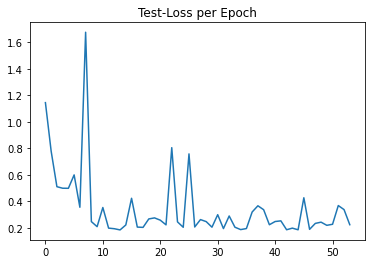

In [58]:
plt.plot(test_losses)
plt.title('Test-Loss per Epoch')

### Definierung und kreieren des Neuronalen Netzes
Als erstes testen wir ein NN mit SGD als Optimizer, mit 3 hidden layers, ohne dropout und ohne batchnorm.


Text(0.5, 1.0, 'Loss per Epoch')

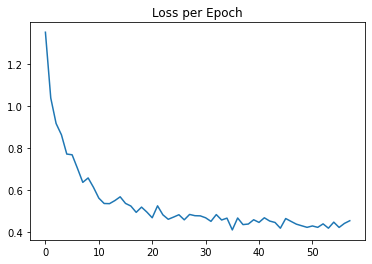

In [54]:
plt.plot(aggregated_losses)
plt.title('Loss per Epoch')

Normalized confusion matrix


<module 'matplotlib.pyplot' from 'C:\\Users\\vince\\anaconda3\\envs\\DEL-Immochallenge\\lib\\site-packages\\matplotlib\\pyplot.py'>

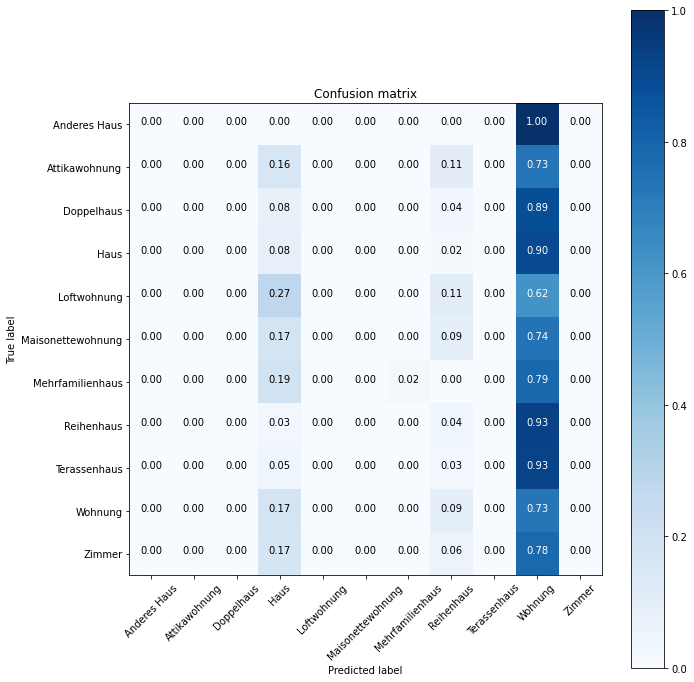

In [55]:
fig, ax = plt.subplots(figsize=(10, 10))
cm = sklearn.metrics.confusion_matrix(y_ohc_test_t.cpu().argmax(axis = 1), model(X_test_t).cpu().argmax(axis = 1))
plot_confusion_matrix(cm, enc.categories_[0], normalize=True)